# RECOMMENDATION TOOLS: Group Project MBD 2022

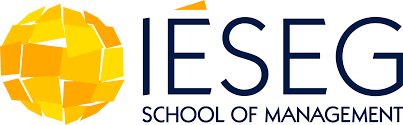

![](https://geniuskitchen.sndimg.com/fdc-new/img/FDC-Logo.png)


This project is about building a system to recommend healthy ingredients to food.com users based on their past recipe reviews. The food.com team wants to provide their users with the Top-N ingredients and include recipes that match the ingredient list. Additionally, the user should be able to replace specific ingredients with relevant alternatives.

 ### Participants:

> **Maria Karakoulian** [LinkedIn](https://www.linkedin.com/in/mkarakoulian/) 
<br> 

> **Arunkkumar Karthikeyan** [LinkedIn](https://www.linkedin.com/in/arunkkumar-karthikeyan/)
<br>

> **Shashank Gollapalli** [LinkedIn](https://www.linkedin.com/in/shashank93/)
<br>

> **Shivaprakash Mallappa** [LinkedIn](https://www.linkedin.com/in/shivaprakash16/)

## Project Setup

### 0. User Defined Functions

**What is this section about?** We are going to create built-in functions for preprocessing and feature engineering analysis. Every function has it's own documentation and will contain debugging and comments that are added for better interpretation.

**0.1. Pre-Processing Functions**

In [1]:
##FUNCTIONS

### PRE-PROCESSING

def clean_reviews(text):
    """
    This user defined function is used to preprocess the reviews for getting alternative ingredients
    """
    # remove numerical numbers and punctuation marks
    text = re.sub(r'[^A-Za-z\s]+|\d+', '', text)
    # convert to lowercase
    text = text.lower()
    # tokenize the text into individual words
    words = word_tokenize(text)
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # join the remaining words back into a single string
    text = ' '.join(words)
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    # remove leading and trailing white spaces
    text = text.strip()
    return text

# Define a function to parse and clean the string
def clean_ingredients(s):
    """
    Given a list of ingredients,strip the ingredient list.
    """
    ingredients_list = ast.literal_eval(s)
    return [ingredient.strip("'") for ingredient in ingredients_list]

**0.2. Feature Engineering**

In [2]:
# Define the criteria for what is considered healthy
def is_healthy(row):
    """
    This user defined function finds out if the ingredients are healthy or non-healthy and assigns a value of 0 and 1 respectively.
    """
    if row['calories'] < 500 and row['fat'] < 15 and row['sat_fat'] < 15 and row['sugar'] < 30 and row['sodium'] < 15:
        return 1
    else:
        return 0

# Merging similar ingredients based on fuzzy string matching
def merge_similar_ingredients(ingredients_list):
    """
    Given a list of ingredients, merge similar ones based on fuzzy string matching.
    """
    merged_list = []
    for ingredient in ingredients_list:
        matches = difflib.get_close_matches(ingredient, merged_list, n=1, cutoff=0.8)
        if matches:
            merged_list[merged_list.index(matches[0])] += ', ' + ingredient
        else:
            merged_list.append(ingredient)
    return merged_list

# Defining table 01 as user, ingredient and rating matrix
def table_01(data):
    """
    This function aims to explode ingredients and selecting user_id and rating
    """
    data=data[['user_id','ingredients','rating']]
    data = data.groupby(['user_id', 'ingredients'])['rating'].last().reset_index()
    data['ingredients'] = data['ingredients'].apply(ast.literal_eval)
    data = data.explode('ingredients')
    #data.columns=['user','item','rating']
    data=data.reset_index(drop=True)
    return data

# Defining prediction for top n users 
def predict_user_topn(model, train, user, topk=5, item_col='recipe_id'):
    """
    Returns topk items for specified user.
    Return type: list

    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids 
    """

    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        # if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

### 1. Import Libraries

In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

# Data Preparation
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack, csr_matrix
from scipy.stats import randint
import difflib
import string
import spacy
import ast
import itertools
import re
import random

# NLTK Package
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Recommender System Modeling
from surprise import Dataset, Reader, SVD, CoClustering, accuracy, BaselineOnly, KNNBasic
from surprise.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer 
from surprise.accuracy import rmse
from surprise.model_selection import RandomizedSearchCV, GridSearchCV
from surprise.prediction_algorithms.matrix_factorization import SVD
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Visualisations
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Miscellaneous
from ieseg_recsys import eval, model
from itertools import combinations
from collections import defaultdict

# NLTK Download packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

pd.options.display.max_colwidth = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akarthikeyan1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akarthikeyan1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akarthikeyan1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Read the Data

In [4]:
# Assign path to the data folder
path = r'C:\Users\akarthikeyan1\OneDrive - IESEG\Msc Big Data Analytics - Arunkkumar Karthikeyan\SEMESTER -02\RECOMMENDATION TOOLS (0758)\INDIVIDUAL PROJECT\data_upload'

In [5]:
# Import reviews data
reviews = pd.read_csv(path + '/train.csv', sep=',', encoding='latin-1')
recipes = pd.read_csv(path +'/metadata.csv', sep=',', encoding='latin-1')

### 3. EDA

In [6]:
# Inspect the train dataset
reviews.head()

,user_id,recipe_id,date,rating,review
0,U6572293,R3561231,31-12-2013,1,Came out perfect. Did not need to keep chilled after it had set. I probably added a bit more zest than listed.
1,U3934946,R6963978,31-12-2013,6,Ridonkulous potato salad! So fresh and flavorful This is going in to my favorites right now!
2,U6572293,R6152071,31-12-2013,6,I made this fudge for this year&#039;s candy/cookie baking day. By the time I got the bottom and middle layer&#039;s spread the top layer had hardened up in the pan. It didn&#039;t want to reheat so I added a bit more milk to it. Next time I would make it up as 3 separate layers instead of making the top and bottom layers at once.
3,U3046817,R3285935,31-12-2013,5,"Great dish...can&#039;t compare to PF Chang&#039;s version, but stands great all on its own! Thank you!"
4,U1579616,R1823461,31-12-2013,6,"Restaurant quality! I used 3 cans of clams instead of 2 and was perfect!! Not sure why others have said it was salty. Even using all the clam juice I still had to add salt. Maybe the salt pork is saltier than bacon? The 2 T of cornstarch was better for me because it made it the perfect consistency. I also used half and half, not milk. I&#039;ve done this in crock pot and stove top and it turned out better on stove top. I don&#039;t think things thicken up as well in the crock pot. GREAT clam chowder and so simple!"


In [7]:
# Check the frequency of user reviews
reviews.groupby('user_id')['recipe_id'].count().sort_values(ascending=False).reset_index()

,user_id,recipe_id
0,U5565883,16
1,U619416,16
2,U6227703,16
3,U6225460,16
4,U6224885,16
...,...,...
11341,U2504281,1
11342,U1136830,1
11343,U8405087,1
11344,U1399039,1


In [8]:
# Check the number of users and recipes
print(reviews.shape, reviews.user_id.nunique(), reviews.recipe_id.nunique())

# Check missing values
print(reviews.isnull().sum())

# Check the data types
print(reviews.dtypes)

# Convert the date column to datetime
reviews['date'] = pd.to_datetime(reviews['date'])

(165226, 5) 11346 62517
user_id      0
recipe_id    0
date         0
rating       0
review       0
dtype: int64
user_id      object
recipe_id    object
date         object
rating        int64
review       object
dtype: object


In [9]:
# Check the distribution of ratings
reviews.groupby('rating')['user_id'].count().sort_values(ascending=False).reset_index()

,rating,user_id
0,6,121049
1,5,27799
2,4,6897
3,1,5561
4,3,2460
5,2,1460


>**The data is very imbalanced, follows a right skewed distribution**

In [10]:
# Inspect the recipes dataset
recipes.head(1)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,buttermilk pie in cornmeal pastry,R5936467,100,U1964167,06-08-1999,"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'pies-and-tarts', 'desserts', 'eggs-dairy', 'oven', 'pies', 'dietary', 'equipment', '4-hours-or-less']","[459.0, 29.0, 163.0, 13.0, 21.0, 32.0, 20.0]",24,"['for pastry: sift together flour and salt', 'stir in cornmeal', 'cut in shortening until mixture resembles fine crumbs', 'stir in grated cheddar cheese', 'sprinkle water over mixture gradually , mixing lightly with fork', 'shape into ball', 'flatten on lightly floured surface', 'roll to about 1 / 8"" thickness', 'line 9"" pie pan', 'trim and flute edge', 'fill and bake as directed below', 'for filling: separate 3 eggs and set whites aside for use in meringue', 'beat yolks , adding sugar gradually', 'cut butter into flour', 'add buttermilk , lemon peel and juice', 'fold in yolks', 'pour into 9"" cornmeal pie shell', 'bake in hot oven 10 minutes', 'reduce temperature to 350f and bake 20 to 25 minutes', 'cool', 'to make meringue: beat 4-5 egg whites in a large bowl with electric mixer on high , until foamy', 'gradually add sugar , beating until stiff peaks form', 'pile meringue lightly over cooled butterrmilk filling', 'bake in moderate oven 12 to 15 minutes']","post by request. an old-fashioned, southern pie.","['flour', 'salt', 'cornmeal', 'shortening', 'cheddar cheese', 'water', 'eggs', 'sugar', 'butter', 'buttermilk', 'lemon zest', 'lemon juice', 'egg whites', 'egg white']",14


In [11]:
# Check the shape of the dataset, number of unique recipes and number of unique recipes
print(recipes.shape, recipes.id.nunique(), recipes.name.nunique())

# Check missing values
print(recipes.isnull().sum())

# Fill the missing values with empty string in the description column
recipes['description'] = recipes['description'].fillna('')

# Print the steps column for the recipes with missing names
print(recipes[recipes['name'].isnull()])

# Replace the missing values in the name column with a string
recipes['name'] = recipes['name'].fillna('horseradish salad')

# Check the data types
print(recipes.dtypes)

(231637, 12) 231637 230185
name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64
       name        id  minutes contributor_id   submitted  \
187012  NaN  R5093434       10       U4209729  27-04-2009   

                                                                                                                                                                                                      tags  \
187012  ['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'low-protein', 'salads', 'easy', 'salad-dressings', 'dietary', 'low-sodium', 'inexpensive', 'low-in-something', '3-steps-or-less']   

                                            nutrition  n_steps  \
187012  [1596.2, 249.0, 155.0, 0.0, 2.0, 112.0, 14.0]        6   

               

In [12]:
# Describe the minutes column
recipes.minutes.describe()

count    2.316370e+05
mean     9.398546e+03
std      4.461963e+06
min      0.000000e+00
25%      2.000000e+01
50%      4.000000e+01
75%      6.500000e+01
max      2.147484e+09
Name: minutes, dtype: float64

In [13]:
# Get the maximum, minimum and mean values of the minutes column
recipes.minutes.max(), recipes.minutes.min(), recipes.minutes.mean()

(2147483647, 0, 9398.546009488984)

In [14]:
# Check the recipes with the maximum values
recipes[recipes['minutes'] == 2147483647]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
141908,no bake granola balls,R5682382,2147483647,U3546577,26-10-2007,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'granola-and-porridge', 'hand-formed-cookies', 'breakfast', 'desserts', 'lunch', 'snacks', '1-day-or-more', 'cookies-and-brownies', 'to-go', 'camping']","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oats and coconut on a cookie sheet', 'place in the oven and toast for about 12 minutes , stirring twice , until lightly browned', 'meanwhile , combine the peanut butter , honey and brown sugar in a saucepan over medium heat , stirring continuously , until ingredients are thoroughly blended and sugar has completely melted', 'add the toasted oats and coconut to the peanut butter mixture , followed by the nuts , raisins and cranberries', 'stir to combine', 'set aside to cool for about 10 minutes', 'working with dampened hands , shape into bite sized balls and refrigerate for an hour', 'i usually let mine sit out for about 15 minutes prior to serving as we like them a little gooey just like my mighty nuts']","healthy snacks that kids (and grown ups) will love! i originally got the recipe from whole foods, then changed it up a bit. this is dairy-free and vegetarian. note: i have many a time made these without toasting the oats and coconut and it works out just fine that way as well :)","['rolled oats', 'unsweetened dried shredded coconut', 'crunchy peanut butter', 'honey', 'brown sugar', 'mixed nuts', 'raisins', 'dried cranberries']",8


In [15]:
# Check the recipes with the minimum value
recipes[recipes['minutes'] == 0].shape

(1094, 12)

In [16]:
# Drop the recipes with the maximum and minimum values
recipes = recipes[recipes['minutes'] != 2147483647]

>We have removed the observation which has an outlier of minutes as 2147483647 for our further analysis

### 4. BaseTable Creation

In [17]:
# Check columns
print('--------------------------------REVIEWS FEATURES ---------------------------------')
print(reviews.columns, recipes.columns)

# Rename the contributor_id column to user_id and id column to recipe_id
recipes.rename(columns={'id': 'recipe_id'}, inplace=True)

--------------------------------REVIEWS FEATURES ---------------------------------
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object') Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')


In [18]:
# Apply the ast.literal_eval function to the nutrition column
recipes['nutrition'] = recipes['nutrition'].apply(lambda x: ast.literal_eval(x))

# Split and convert the values in the nutrition variable into separate variables
recipes['calories'] = recipes['nutrition'].apply(lambda x: x[0] if len(x) > 0 else None)
recipes['fat'] = recipes['nutrition'].apply(lambda x: x[1] if len(x) > 1 else None)
recipes['sugar'] = recipes['nutrition'].apply(lambda x: x[2] if len(x) > 2 else None)
recipes['sodium'] = recipes['nutrition'].apply(lambda x: x[3] if len(x) > 3 else None)
recipes['protein'] = recipes['nutrition'].apply(lambda x: x[4] if len(x) > 4 else None)
recipes['sat_fat'] = recipes['nutrition'].apply(lambda x: x[5] if len(x) > 5 else None)
recipes['carbs'] = recipes['nutrition'].apply(lambda x: x[6] if len(x) > 6 else None)

# Drop the original 'nutrition' column
recipes.drop('nutrition', axis=1, inplace=True)

In [19]:
# Apply the is_healthy function to each row of the DataFrame
recipes['healthy'] = recipes.apply(is_healthy, axis=1)

# Check the distribution of healthy recipes
recipes.healthy.value_counts()

0    200205
1     31431
Name: healthy, dtype: int64

In [20]:
# Check the number of unique recipes in recipes and reviews
print(recipes.recipe_id.nunique(), reviews.recipe_id.nunique(), len(np.intersect1d(recipes.recipe_id.nunique(), reviews.recipe_id.nunique())))

231636 62517 0


In [21]:
# Merge the reviews and recipes datasets on user_id and recipe_id
base = reviews.merge(recipes, on=['recipe_id'], how = 'left')

# Check the missing values
print('--------------------------CHECKING FOR NULL VALUES ---------------------------------------')
print(base.isna().sum())

# Drop the missing values
base.dropna(inplace=True)

# Check the shape of basetable
print('--------------------------CHECKING SHAPE OF BASETABLE ---------------------------------------')
print(base.shape)

--------------------------CHECKING FOR NULL VALUES ---------------------------------------
user_id           0
recipe_id         0
date              0
rating            0
review            0
name              2
minutes           2
contributor_id    2
submitted         2
tags              2
n_steps           2
steps             2
description       2
ingredients       2
n_ingredients     2
calories          2
fat               2
sugar             2
sodium            2
protein           2
sat_fat           2
carbs             2
healthy           2
dtype: int64
--------------------------CHECKING SHAPE OF BASETABLE ---------------------------------------
(165224, 23)


>**Filtering:** We have filtered the records with recipes having more than 10+ reviews and users with more than 5+ reviews for our analysis. By filtering recipes with less than 10 reviews, I am only considering recipes that have been reviewed at least 10 times, which could indicate that they are more popular and have more reliable ratings. Similarly, by filtering users with less than 5 reviews, I am only considering users who have reviewed at least 5 recipes, which could indicate that they are more engaged with the platform and have more reliable ratings. Overall, filtering recipes and users can help to improve the quality of my analysis and make my recommendations more accurate.

In [22]:
# filter recipes with 10+ reviews
review_count = base["recipe_id"].value_counts()

min_count = 10
recipe_filter = list(review_count[review_count >= min_count].index)
review_filter = base[base['recipe_id'].isin(recipe_filter)].reset_index(drop=True)

print(f"Removed {len(review_count) - (review_count > min_count).sum()} recipes")

# filter users with 5+ reviews
review_count = review_filter["user_id"].value_counts()

min_count = 5
user_filter = list(review_count[review_count >= min_count].index)
base_filter = review_filter[review_filter['user_id'].isin(user_filter)].reset_index(drop=True)

print(f"Removed {len(review_count) - (review_count >= min_count).sum()} user")

Removed 60444 recipes
Removed 4612 user


>**Sorting and Filtering:** We have considered only the latest 10% data for our analysis to resolve the memory issue and we have used the same data for all our below analysis and compared our results 

In [23]:
# Sort the DataFrame by date in descending order
base = base.sort_values(by='date', ascending=False)

# Calculate the number of observations to select
n = int(len(base) * 0.1)

# Select the latest 10% of observations
final_basetable = base.head(n)

> **User-Defined Functions :** At this stage we have used user defined function to clean set of text (reviews), using libraries to correctly remove stop words, normalize vocabulary for our recommendation system. Function used: `clean_reviews`

In [24]:
# Applying the clean and split sentences function on review variable
final_basetable['review'] = final_basetable['review'].apply(clean_reviews)

In [25]:
# create a regular expression pattern to match the words after replace, substitute or instead
pattern = r"(?i)(?:(?:used|substitute|instead|replace|add|omit)\s+(?=\w))+(\w+\s*)+"

# create an empty list to store the matched words
matched_words = []

# loop through each row of the full_name column and find the matched words
for name in final_basetable['review']:
    match = re.search(pattern, name)
    if match:
        matched_words.append(match.group().strip())

# print the list of matched words
print(matched_words)

['instead slicing meaty toothsome effect', 'used half oil butter flour still came rich tasty also used frozen corn canned corn hand ham use ailing hubby three fortifying bowls great tip making roux microwave', 'used two sizes experiment see happens thanks', 'add cherry juice next sheets set', 'used pound chuck roast thanks recipe', 'add cumin didnt also used driedpowdered onion instead chopped made crock pot hour setting think', 'used cans clams instead perfect sure others said salty even using clam juice still add salt maybe salt pork saltier bacon cornstarch better made perfect consistency also used half half milk ive done crock pot stove top turned better stove top dont think things thicken well crock pot great clam chowder simple', 'instead making top bottom layers', 'used make stromboli simply amazing followed recipe exactly couldnt easier original cook loosely wrapped dough final step plastic wrap turned fine recipe enough make four large strombolis using years come thank', 'subs

>**Source code:** https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=01de5057bc78667a40a83c2bce87649e0a4b1692
Includes -> This research paper demonstrates results that recipe ratings can be well predicted with features derived from combinations of ingredient networks

In [26]:
# Define the regular expression pattern
pattern = r'\b(\w+(?:\s+\w+)*)\s+(used|placed|subtitute|place|replace)\s+(\w+(?:\s+\w+)*)\b'

# Define a list to store the results
results = []

# Loop over each review in the DataFrame
for idx, row in final_basetable.iterrows():
    # Find all matches of the pattern in the review
    matches = re.findall(pattern, row['review'])
    
    # Loop over each match
    for match in matches:
        before = match[0]
        keyword = match[1]
        after = match[2]
        
        # Split the matched text into words and take the first/last 4 words
        before_words = before.split()[-2:]
        after_words = after.split()[:2]
        
        # Add the result to the list
        result = {
            'recipe_id': row['recipe_id'],
            'date': row['date'],
            'before': ' '.join(before_words),
            'keyword': keyword,
            'after': ' '.join(after_words)
        }
        results.append(result)

# Convert the results to a DataFrame
first = pd.DataFrame(results)
pd.options.display.max_colwidth = None
first.head(10)

,recipe_id,date,before,keyword,after
0,R8736622,2013-12-31,tasty also,used,frozen corn
1,R6499305,2013-12-31,rice paper,used,two sizes
2,R7490622,2013-12-31,thing changed,used,pound chuck
3,R7774508,2013-12-31,didnt also,used,driedpowdered onion
4,R1823461,2013-12-31,consistency also,used,half half
5,R8914734,2013-12-30,scratch delicious,used,make stromboli
6,R2838779,2013-12-30,consistency flavor,used,honey dough
7,R5536619,2013-12-30,huge hit,used,watermelon jello
8,R2082364,2013-12-30,flavorful rice,used,jasmine rice
9,R8132798,2013-12-30,breakfast morning,used,oregonmade nancys


In [27]:
# Define the regular expression pattern
pattern = r'\b(\w+(?:\s+\w+)*)\s+(instead)\s+(\w+(?:\s+\w+)*)\b'

# Define a list to store the results
results = []

# Loop over each review in the DataFrame
for idx, row in final_basetable.iterrows():
    # Find all matches of the pattern in the review
    matches = re.findall(pattern, row['review'])
    
    # Loop over each match
    for match in matches:
        before = match[0]
        keyword = match[1]
        after = match[2]
        
        # Split the matched text into words and take the first/last 4 words
        before_words = before.split()[-2:]
        after_words = after.split()[:2]
        
        # Add the result to the list
        result = {
            'recipe_id': row['recipe_id'],
            'date': row['date'],
            'before': ' '.join(before_words),
            'keyword': keyword,
            'after': ' '.join(after_words)
        }
        results.append(result)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df.head(10)

,recipe_id,date,before,keyword,after
0,R7903679,2013-12-31,quarter mushrooms,instead,slicing meaty
1,R7774508,2013-12-31,driedpowdered onion,instead,chopped made
2,R1823461,2013-12-31,cans clams,instead,perfect sure
3,R6152071,2013-12-31,separate layers,instead,making top
4,R3130371,2013-12-29,used basil,instead,thyme cut
5,R9592927,2013-12-27,dried basil,instead,fresh still
6,R1144688,2013-12-26,used halfandhalf,instead,heavy cream
7,R8098483,2013-12-26,blonde milky,instead,dark cooked
8,R7611869,2013-12-25,lemon extract,instead,vanilla change
9,R4082579,2013-12-23,vanilla extract,instead,stuck recipe


### 4.1 Co-Occurence & Pointwise mutual information

> **User-Defined Functions :** We have used user defined function to clean set of text (ingredients), using libraries to parse and clean the string. Function used: `clean_ingredients`

In [28]:
# apply the function to the 'ingredients' column
final_basetable["ingredients_cooccur"] = final_basetable["ingredients"].apply(clean_ingredients)

# show the cleaned dataframe
final_basetable["ingredients_cooccur"].head(10)

0                                                                                                                [semi-sweet chocolate chips, sweetened condensed milk, pecans, orange zest]
10                                                                                     [green onions, onion, garlic cloves, butter, fresh mushrooms, wine, worcestershire sauce, beef broth]
1                    [red potatoes, cider vinegar, mayonnaise, mustard powder, fresh parsley, fresh tarragon, garlic, cornichons, red onion, celery, kosher salt, fresh ground black pepper]
17                                                                 [onion, green bell pepper, smoked sausage, butter, flour, evaporated milk, potatoes, whole kernel corn, water, olive oil]
16                                                                    [green apples, fresh lemon juice, brown sugar, walnuts, unsalted butter, caster sugar, rice paper sheets, icing sugar]
15                                   [noodles, celery, 

>Source code: https://www.kaggle.com/code/halflings/ingredient-recommender-system/notebook

In [29]:
cooccurance_counts = defaultdict(int)
ingrident_count = defaultdict(int)

for ingredients in final_basetable.ingredients_cooccur:
    for ing in ingredients:
        ingrident_count[ing] += 1
    for ingridient1, ingridient2 in combinations(set(ingredients), 2):
        cooccurance_counts[tuple(sorted([ingridient1, ingridient2]))] += 1


cooccurance = []

for (ingridient1, ingridient2), cooc in cooccurance_counts.items():
    ingridient1_count = ingrident_count[ingridient1]
    ingridient2_count = ingrident_count[ingridient2]
    cooccurance.append((ingridient1, ingridient2, ingridient1_count, ingridient2_count, cooc))

cooccurance_df = pd.DataFrame(cooccurance, columns=['ingredient1', 'ingredient2', 'ingredient1_count', 'ingredient2_count', 'coocurrence'])
cooccurance_df.head(5)

,ingredient1,ingredient2,ingredient1_count,ingredient2_count,coocurrence
0,pecans,semi-sweet chocolate chips,309,191,17
1,semi-sweet chocolate chips,sweetened condensed milk,191,152,23
2,orange zest,semi-sweet chocolate chips,65,191,5
3,pecans,sweetened condensed milk,309,152,5
4,orange zest,pecans,65,309,7


>**Interpretation on Co-Occurence**: 
- This code is creating a co-occurrence matrix for pairs of ingredients in final_basetable. The code first initializes two dictionaries: cooccurance_counts and ingredient_count. 
- The former will be used to count the number of times each pair of ingredients co-occur, while the latter will be used to count the total number of times each individual ingredient appears in the dataset. 
- The code then loops through each set of ingredients in the final_basetable, and for each ingredient it increments its count in ingredient_count. It then uses the combinations function from the itertools module to generate all pairs of ingredients in the set, and increments the count in cooccurance_counts for each pair.
- After all pairs have been counted, the code creates a list of tuples cooccurance that contains the ingredient pair, the count for the first ingredient, the count for the second ingredient, and the co-occurrence count. 
- This list is then used to create a pandas DataFrame cooccurance_df with columns for each of these values.
- The resulting DataFrame will have a row for each pair of ingredients that co-occur, along with the number of times each ingredient appears in the dataset and the number of times the pair co-occur.

>The below code calculates the pointwise mutual information (PMI) between ingredient pairs. PMI is a statistical measure used to determine the association between two items, in this case, ingredients. The PMI measures how much more likely two ingredients are to co-occur together in a recipe than if they were occurring randomly. It seems that shrimp has occured more frequently with other ingredients

In [30]:
PMI_values = []

num_recipes = len(final_basetable)

for (ingredient1, ingredient2), cooc in cooccurance_counts.items():
    Prob_A = ingrident_count[ingredient1] / num_recipes
    prob_b = ingrident_count[ingredient2] / num_recipes
    Prob_A_B = cooc / num_recipes
    PMI = np.log(Prob_A_B / (Prob_A * Prob_A_B))
    PMI_values.append((ingridient1, ingredient2, Prob_A, prob_b, Prob_A_B, PMI))

PMI_df = pd.DataFrame(PMI_values, columns=['ingredient1', 'ingredient2', 'Prob_A', 'prob_b', 'Prob_A_B', 'PMI'])
PMI_df.sort_values('PMI', ascending=False).head(10)

,ingredient1,ingredient2,Prob_A,prob_b,Prob_A_B,PMI
47079,bell pepper,white pepper,0.000061,0.016039,0.000061,9.712448
65093,bell pepper,dill,0.000061,0.001695,0.000061,9.712448
65118,bell pepper,clams,0.000061,0.000605,0.000061,9.712448
34531,bell pepper,whipped cream,0.000061,0.003208,0.000061,9.712448
65116,bell pepper,onion,0.000061,0.185934,0.000061,9.712448
65114,bell pepper,white pepper,0.000061,0.016039,0.000061,9.712448
65113,bell pepper,flour,0.000061,0.147742,0.000061,9.712448
65112,bell pepper,half-and-half,0.000061,0.010289,0.000061,9.712448
65111,bell pepper,fresh parsley,0.000061,0.036678,0.000061,9.712448
65105,bell pepper,italian seasoning,0.000061,0.011923,0.000061,9.712448


In [31]:
# Tokenize, case conversion & only alphabetic
final_basetable['review'] = final_basetable['review'].apply(lambda txt: [word.lower() for word in word_tokenize(txt) if word.isalpha()])

# Setup stop words list
stop_words = stopwords.words('english') + ['nan', 'recipe', 'made', 'make', 'one', 'really', 'instead', 'eat', 'used', 'use', 'get', 'thanks', 'great', 'time']

# Filter out numbers and stop words
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [token for token in lst_token if not token.isnumeric() and token not in stop_words])

#lemmatize words
lemmatizer = WordNetLemmatizer()
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [lemmatizer.lemmatize(token) for token in lst_token])

# Filter if there is still any stop words
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [token for token in lst_token if token not in stop_words])

# Remove None and take token that are greater than a length of 2
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [token for token in lst_token if token is not None and len(token) > 2])

### 5. Unify the Ingredients

In [32]:
ingredients = final_basetable[['recipe_id', 'ingredients']]

# convert the string representation of the list to a list of strings
ingredients['ingredients'] = ingredients['ingredients'].apply(ast.literal_eval)

# Explode the ingredients column
ingredients = ingredients.explode('ingredients')
ingredients

,recipe_id,ingredients
0,R3561231,semi-sweet chocolate chips
0,R3561231,sweetened condensed milk
0,R3561231,pecans
0,R3561231,orange zest
10,R7903679,green onions
...,...,...
16289,R5400211,garlic powder
16289,R5400211,salt
16289,R5400211,black pepper
16289,R5400211,parmesan cheese


In [33]:
# Grouping the ingredients and finding the no of unique recipes
i = ingredients.groupby('ingredients')['recipe_id'].nunique().sort_values(ascending=False).reset_index()
i

,ingredients,recipe_id
0,salt,4571
1,butter,2801
2,sugar,2243
3,onion,1989
4,water,1797
...,...,...
5264,fresh cayenne pepper,1
5265,fresh cayenne peppers,1
5266,fresh cilantro stems,1
5267,potato buns,1


In [34]:
# Converting the unique ingredients as a list
ingredients_list = i['ingredients'].tolist()
print(ingredients_list)

['salt', 'butter', 'sugar', 'onion', 'water', 'eggs', 'olive oil', 'flour', 'garlic cloves', 'milk', 'pepper', 'baking powder', 'brown sugar', 'garlic', 'all-purpose flour', 'egg', 'baking soda', 'vegetable oil', 'parmesan cheese', 'salt and pepper', 'vanilla', 'garlic powder', 'black pepper', 'cinnamon', 'lemon juice', 'sour cream', 'oil', 'vanilla extract', 'paprika', 'chicken broth', 'onions', 'soy sauce', 'celery', 'cream cheese', 'cheddar cheese', 'tomatoes', 'honey', 'garlic clove', 'worcestershire sauce', 'unsalted butter', 'cornstarch', 'mayonnaise', 'chili powder', 'fresh parsley', 'fresh ground black pepper', 'cayenne pepper', 'carrots', 'ground cumin', 'carrot', 'kosher salt', 'granulated sugar', 'extra virgin olive oil', 'parsley', 'ground cinnamon', 'potatoes', 'bacon', 'green onions', 'nutmeg', 'ground beef', 'dried oregano', 'fresh lemon juice', 'green onion', 'ground black pepper', 'dijon mustard', 'cumin', 'margarine', 'walnuts', 'boneless skinless chicken breasts', 'o

In [35]:
# Applying the similar ingredient function for the ingredient list
merge_similar_ingredients(ingredients_list)

['salt',
 'butter, batter',
 'sugar',
 'onion, onions',
 'water',
 'eggs, egg',
 'olive oil',
 'flour',
 'garlic cloves, garlic clove',
 'milk',
 'pepper, pepperoni',
 'baking powder, mango powder',
 'brown sugar, dark brown sugar',
 'garlic',
 'all-purpose flour, all-purpose white flour',
 'baking soda',
 'vegetable oil, light vegetable oil',
 'parmesan cheese, american cheese',
 'salt and pepper, salt & pepper',
 'vanilla',
 'garlic powder, rice powder',
 'black pepper, black peppercorns',
 'cinnamon, cinnamon oil',
 'lemon juice, lemon, juice of',
 'sour cream',
 'oil',
 'vanilla extract, pure vanilla extract',
 'paprika',
 'chicken broth, rich chicken broth',
 'soy sauce, pesto sauce',
 'celery',
 'cream cheese, light cream cheese',
 'cheddar cheese, sharp cheddar cheese',
 'tomatoes',
 'honey',
 'worcestershire sauce, worchestershire sauce',
 'unsalted butter, salted butter',
 'cornstarch',
 'mayonnaise, soy mayonnaise',
 'chili powder, red chili powder',
 'fresh parsley, fresh pa

In [36]:
# Rename the ingredients
replace_dict = {'lime, juice of': 'lime juice',
                'limes, juice of': 'lime juice', 
                "rose's lime juice": 'lime juice',
                'fresh lime juice': 'lime juice',
                'key limes': 'key lime',
                'limes' : 'lime',
                'lime slice': 'lime',
                'lime slices': 'lime',
                'lime wedge': 'lime',
                'lime wedges': 'lime',
                'lime rind': 'lime zest',
                'limes, juice and zest of': 'lime juice',
                'lime, zest of': 'lime zest',
                'limes, zest of': 'lime zest',
                'lime, juice and zest of': 'lime juice', 
                'lemon, juice of': 'lemon juice',
                'lemons, juice of': 'lemon juice',
                'fresh lemon juice': 'lemon juice',
                'fresh lemon zest': 'lemon zest',
                'lemons, juice and rind of': 'lemon juice',
                'fresh meyer lemon juice': 'meyer lemon juice',
                'lemons': 'lemon',
                'lemon slice': 'lemon',
                'lemon slices': 'lemon',
                'lemon, zest of': 'lemon zest',
                'lemon rind': 'lemon zest',
                'lemons rind': 'lemon zest',
                'fresh lemon rind': 'lemon zest',
                'lemon, rind of': 'lemon zest',
                'lemon wedge': 'lemon',
                'lemon wedges': 'lemon',
                'lemon, zest and juice of': 'lemon zest',
                'lemon pepper seasoning': 'lemon pepper',
                'lemon-pepper seasoning': 'lemon pepper',
                'fresh lemongrass': 'lemongrass',
                'fresh lemon': 'lemon',
                'preserved lemons' : 'preserved lemons',
                'meyer lemons': 'meyer lemon',
                'orange juice concentrate': 'frozen orange juice concentrate',
                'lemon juice concentrate': 'frozen lemon juice concentrate',
                'lemonade concentrate': 'frozen lemon juice concentrate',
                'apple juice concentrate': 'frozen apple juice concentrate',
                'onions': 'onion',
                'green onions': 'green onion',
                'green onion stems': 'green onion',
                'green onion tops': 'green onion',
                'salt & pepper': 'salt and pepper',
                'seasoning salt': 'salt',
                'season salt': 'salt',
                'savor salt seasoning': 'salt',
                "mccormick's seasoning salt": 'salt',
                'sea salt': 'salt',
                'salt & freshly ground black pepper': 'salt and pepper',
                'salt & fresh ground pepper': 'salt and pepper',
                'salt and black pepper': 'salt and pepper',
                'salt and fresh pepper': 'salt and pepper',
                'coarse salt': 'kosher salt',
                'coarse sea salt': 'kosher salt',
                'table salt': 'salt',
                'fine sea salt': 'salt',
                'fine salt': 'salt',
                'kosher salt & freshly ground black pepper': 'salt and pepper',
                "lawry's seasoned salt": 'salt',
                'canning salt': 'pickling salt',
                'season-all salt': 'salt',
                'salted butter': 'butter',
                'real butter': 'butter',
                'creamy peanut butter': 'peanut butter',
                'crunchy peanut butter': 'peanut butter',
                'chunky peanut butter': 'peanut butter',
                'smooth peanut butter': 'peanut butter',
                'natural-style peanut butter': 'peanut butter',
                'natural-style chunky peanut butter': 'peanut butter',
                'unsalted creamy peanut butter': 'unsalted peanut butter',
                'miniature peanut butter cups': 'mini peanut butter cups',
                "reese's peanut butter cups": 'peanut butter cups',
                'peanut butter cup': 'peanut butter cups',
                'sweet unsalted butter': 'unsalted butter',
                'sweet creamy butter': 'unsalted butter',
                "land o' lakes butter": 'butter',
                'pillsbury grands refrigerated buttermilk biscuits': 'refrigerated buttermilk biscuits',
                'ready-to-bake refrigerated buttermilk flaky biscuits': 'refrigerated buttermilk biscuits',
                'saltine': 'saltine crackers',
                'butter flavored crackers': 'butter crackers',
                'butter flavored cracker': 'butter crackers',
                'buttery cracker': 'butter crackers',
                'buttery crackers': 'butter crackers',
                'butter lettuce': 'butterhead lettuce',
                'buttermilk ranch salad dressing mix': 'buttermilk ranch dressing', 
                'no-salt-added chicken stock': 'no-salt-added chicken broth',
                'chicken stock': 'chicken broth',
                'boneless skinless chicken breast halves': 'chicken breasts',
                'boneless skinless chicken breasts': 'chicken breasts',
                'boneless skinless chicken breast': 'chicken breasts',
                'boneless chicken breasts': 'chicken breasts',
                'chicken breast': 'chicken breasts',
                'chicken breast halves': 'chicken breasts',
                'cooked chicken': 'chicken',
                'boneless skinless chicken thighs': 'chicken thighs',
                'chicken pieces': 'chicken',
                'beef stock': 'beef broth',
                'boneless beef chuck roast': 'roast beef',
                'beef bouillon': 'beef bouillon cubes',
                'beef bouillon cube': 'beef bouillon cubes',
                'beef roast': 'roast beef',
                'white fish fillets': 'white fish fillet',
                'catfish fillets': 'catfish fillet',
                'fish fillets': 'fish fillet',
                'fresh ground black pepper': 'black pepper',
                'ground black pepper': 'black pepper',
                'crushed red pepper flakes': 'red pepper flakes',
                'fresh ground pepper': 'black pepper',
                'ground pepper': 'black pepper',
                'fresh coarse ground black pepper': 'black pepper',
                'cracked black pepper': 'black pepper',
                'bell peppers': 'bell pepper',
                'jalapeno peppers': 'jalapeno pepper',
                'red bell peppers': 'red bell pepper',
                'green bell peppers': 'green bell pepper',
                'fresh black pepper': 'black pepper',
                'hot pepper flakes': 'hot red pepper flakes',
                'white sugar': 'sugar',
                'golden brown sugar': 'ligh brown sugar',
                'all-purpose flour': 'flour',
                'white flour': 'flour',
                'unbleached all-purpose flour': 'unbleached flour',
                'self raising flour': 'self-rising flour',
                'flour tortilla': 'flour tortillas',
                'white whole wheat flour': 'flour',
                'potato': 'potatoes',
                'sweet potato': 'sweet potatoes',
                'russet potato': 'russet potatoes',
                'diced tomato': 'tomatoes',
                'diced tomatoes': 'tomatoes',
                'chopped tomatoes': 'tomatoes',
                'chopped tomatoe': 'tomatoes',
                'fresh tomatoes': 'tomatoes',
                'sun-dried tomato': 'sun-dried tomatoes',
                'whole tomatoes': 'whole tomatoes',
                'grape tomatoes': 'cherry tomatoes',
                'whole canned tomatoes': 'canned tomatoes',
                'pure vanilla extract': 'vanilla extract',
                'french vanilla instant pudding': 'instant vanilla pudding',
                'vanilla bean': 'vanilla beans',
                'vanilla wafer': 'vanilla wafers',
                'soya sauce': 'soy sauce',
                'tamari soy sauce': 'soy sauce',
                'lea & perrins worcestershire sauce': 'worcestershire sauce',
                'dried chili pepper flakes': 'chili flakes',
                'carrot': 'carrots',
                'fresh carrot': 'carrots',
                'cayenne': 'cayenne pepper',
                'ground cayenne pepper': 'cayenne pepper',
                'red cayenne pepper': 'cayenne pepper',
                'fresh cayenne peppers': 'fresh cayenne peppers',
                'egg': 'eggs',
                'egg whites': 'egg white',
                'egg yolks': 'egg yolk',
                'eggplants': 'eggplant',
                'extra large eggs': 'extra-large eggs',
                'dry mustard': 'mustard powder',
                'green zucchini': 'zucchini',
                'fresh zucchini': 'zucchini',
                'raw zucchini': 'zuccini',
                'basil leaves': 'basil',
                'fresh basil leaf': 'fresh basil',
                'fresh basil leaves': 'fresh basil',
                'dried basil leaves': 'dried basil',
                'dry basil': 'dried basil',
                'shredded cheddar cheese': 'cheddar cheese',
                'cucumbers': 'cucumber',
                'mushroom': 'mushrooms',
                'fresh mushrooms': 'mushrooms',
                'button mushroom': 'button mushrooms',
                'white button mushrooms': 'button mushrooms',
                'portabella mushroom': 'portabella mushrooms',
                'jalapeno': 'jalapeno pepper',
                'jalapeno peppers': 'jalapeno pepper',
                'jalapenos': 'jalapeno pepper',
                'jalapeno chiles': 'jalapeno pepper',
                'fresh jalapenos': 'jalapeno pepper',
                'fresh jalapeno pepper': 'jalapeno pepper',
                'fresh jalapeno peppers': 'jalapeno pepper',
                'cooked rice': 'rice',
                'long grain rice': 'rice',
                'white rice': 'rice',
                'cooked brown rice': 'brown rice',
                'cooked white rice': 'rice',
                'long-grain white rice': 'rice',
                'cooked long-grain rice': 'rice',
                'long grain brown rice': 'brown rice',
                'lasagna noodle': 'lasagna noodles',
                'quick-cooking oats': 'quick oats',
                "devil's food cake mix": 'cake mix'
}

In [37]:
# Applying the renmaed ingredient list on final_basetable
final_basetable['ingredients'] = final_basetable['ingredients'].apply(lambda x: replace_dict[x] if x in replace_dict else x)

### 6. Descriptive Analytics

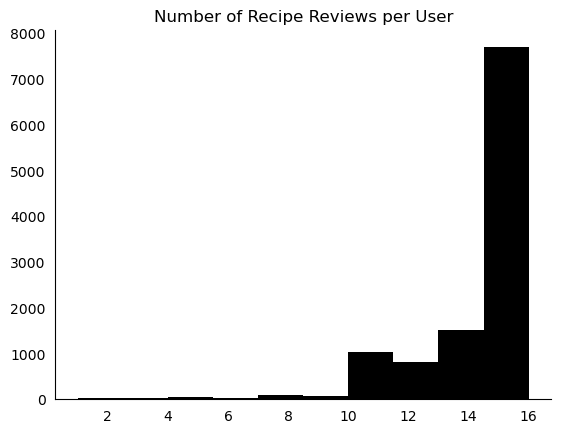

In [38]:
# Number of Recipe Reviews per User
base.groupby('user_id')['recipe_id'].count().sort_values(ascending=False).reset_index().hist(bins=10, color='black')

# Add the title
plt.title('Number of Recipe Reviews per User')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# remove the gridlines
plt.grid(False)

# Remove the ticks                                     
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

>***Majority of users have made less than 2 reviews***

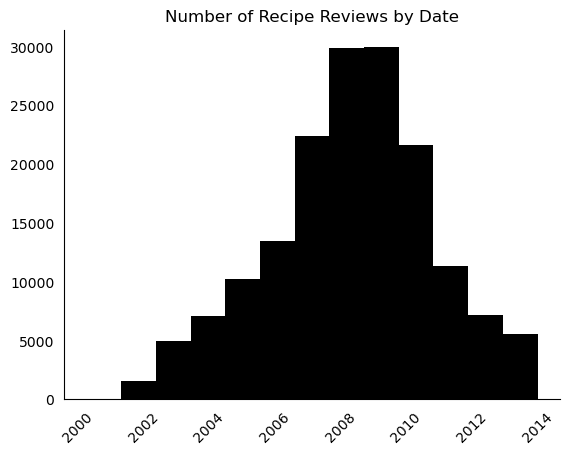

In [39]:
# Check the date range of reviews
base['date'].hist(bins=13, color='black')

# Add the title
plt.title('Number of Recipe Reviews by Date')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# remove the gridlines
plt.grid(False)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Remove the ticks                                     
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

>***Majority of the reviews have been made between 2006 and 2011***

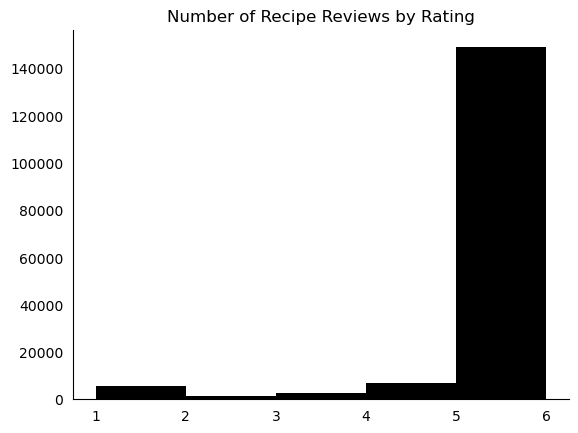

In [40]:
# Number of Recipe Reviews by Rating
base['rating'].hist(bins=5, color='black')

plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

# Add the title
plt.title('Number of Recipe Reviews by Rating')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# remove the gridlines
plt.grid(False)

# Remove the ticks                                     
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

>***The data is very imbalanced, follows a right skewed distribution, with most reviews having a rating of 6.***

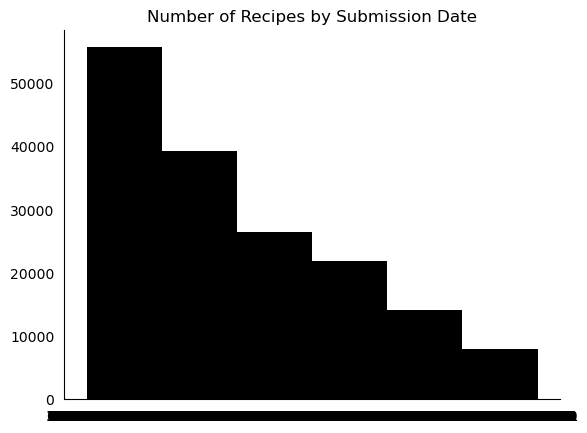

In [41]:
# Check the date range of recipe submissions
base['submitted'].hist(bins=6, color='black')

# Add the title
plt.title('Number of Recipes by Submission Date')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# remove the gridlines
plt.grid(False)

# Remove the ticks                                     
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

>***Most recipes are submitted between 2001 and 2005.***

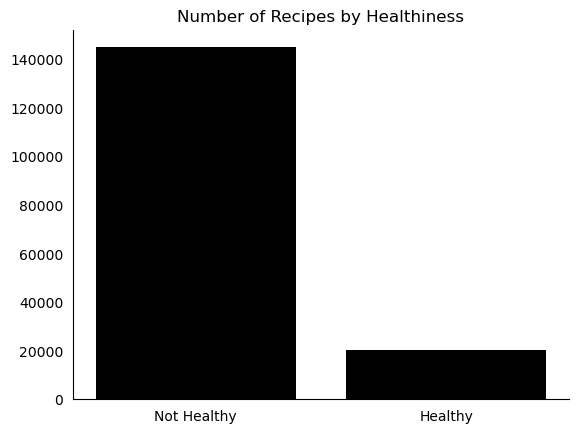

In [42]:
healthy_counts = base['healthy'].value_counts()
plt.bar(healthy_counts.index.astype(str), healthy_counts, color='black', tick_label=['Not Healthy', 'Healthy'])

# Add the title
plt.title('Number of Recipes by Healthiness')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove the ticks                                     
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

>***The majority of the recipes are not healthy.***

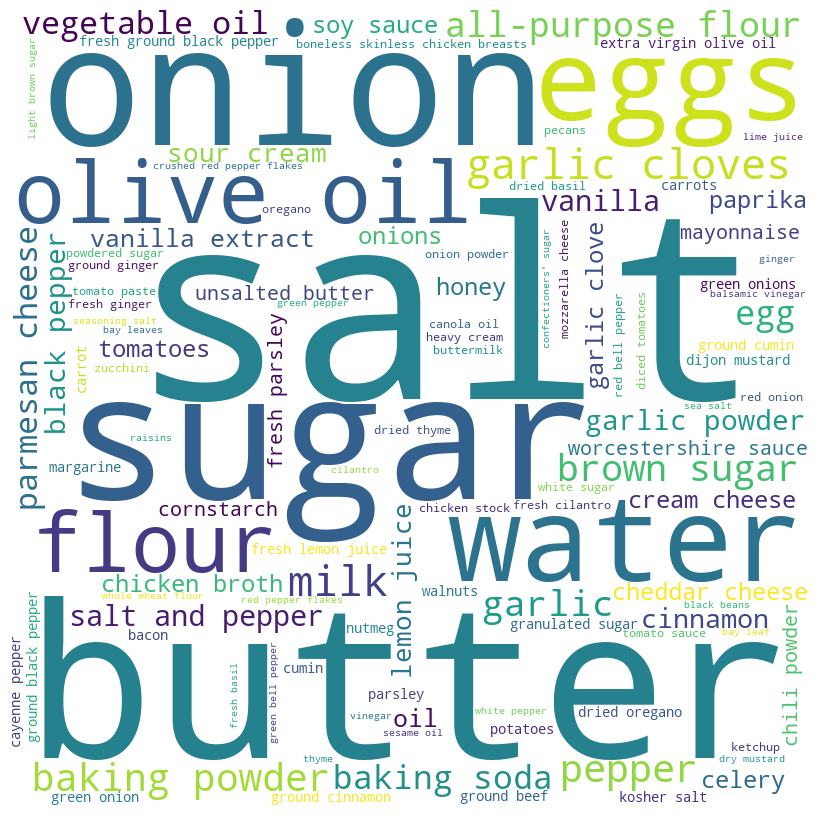

In [43]:
# Create dictionary from dataframe
word_dict = {}
for index, row in i.iterrows():
    word_dict[row['ingredients']] = row['recipe_id']

# Generate wordcloud from dictionary
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word_dict)

# Plot the wordcloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# Show the plot
plt.show()

### 7. Train-Test Split

In [62]:
# split data into train and test sets (considering 70% for train set and 30% for test set)
train, test = train_test_split(final_basetable, test_size=0.3, random_state=42)

# split train data into train and validation sets (considering 50% for train set and 20% for test set)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# reset index for all dataframes
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

print(final_basetable.shape)
print(train.shape)
print(test.shape)
print(val.shape)

(16522, 24)
(9252, 24)
(4957, 24)
(2313, 24)


### 8. Creating the first Table

In [48]:
# Applying the function of user item rating (first table)
train_t1=table_01(train)
val_t1=table_01(val)
test_t1=table_01(test)

print(train_t1.shape)
print(val_t1.shape)
print(test_t1.shape)

(85937, 3)
(21703, 3)
(46166, 3)


### 7.  Content Based Approach

In [49]:
# Create 2 tables with the necessary columns
train_t2 = train[['user_id', 'ingredients', 'review']]

In [50]:
# Exploding the ingredient list
train_t2['ingredients'] = train_t2['ingredients'].apply(ast.literal_eval)
train_t2 = train_t2.explode('ingredients')

In [51]:
# TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5)

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in train_t2['review']])

print(dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out(), index = train_t1['ingredients'])

# Reset index to convert items into a regular column
df_dtm = df_dtm.reset_index()

# Drop duplicates based on the items column
df_dtm = df_dtm.drop_duplicates(subset='ingredients')

# Set the items column back as the index
df_dtm = df_dtm.set_index('ingredients')

print(df_dtm.shape)
df_dtm.head()

(85937, 12634)
(4262, 12634)


,aaaaaaaall,aaaaing,aaaamazing,aaargh,aahhd,aahing,aarp,abandoned,abby,abc,...,zuch,zuchini,zuchinimushroomscauliflower,zuchinni,zuke,zurie,zwt,zwtemerald,zwts,zwtspainportugal
ingredients,,,,,,,,,,,,,,,,,,,,,
potato,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
onion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
celery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
carrot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
margarine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Create a Reader object with a rating scale of 1 to 6
reader = Reader(rating_scale=(1.0, 6.0))

# Load the training data into a Surprise Dataset object and build the full train set
df_train = Dataset.load_from_df(train_t1, reader).build_full_trainset()

# Convert the test data into a list of tuples for testing
df_val = list(val_t1.itertuples(index=False, name=None))

# Convert the test data into a list of tuples for testing
df_test = list(test_t1.itertuples(index=False, name=None))

In [53]:
# content-based
cb = model.ContentBased(NN=10)
cb.fit(df_dtm)
cb.fit_ratings(df_train)

# predict test ratings
cb_pred_val = cb.test(df_val)
cb_pred_test = cb.test(df_test)

In [54]:
print("Content based RMSE: ")

print("Validation Set: ", accuracy.rmse(cb_pred_val))
print("Test Set: ", accuracy.rmse(cb_pred_test))

# percentage impossible predictions
perc_impossible = np.sum([1 for i in cb_pred_test if i.details["was_impossible"]]) / len(cb_pred_test)
print(f"Impossible for Test Set: {perc_impossible:.4f}")

Content based RMSE: 
RMSE: 1.5003
Validation Set:  1.5003237411003447
RMSE: 1.4851
Test Set:  1.4851358554555742
Impossible for Test Set: 0.2145


### 8. Collaborative Filtering Approach

### 8.1. User-Based CF

In [74]:
# Load the train and test datasets into Surprise format
reader = Reader(rating_scale=(1, 6))
train_data = Dataset.load_from_df(train_t1[['user_id', 'ingredients', 'rating']], reader)
trainset = train_data.build_full_trainset()
val_data = list(val_t1[['user_id', 'ingredients', 'rating']].itertuples(index=False, name=None))
test_data = list(test_t1[['user_id', 'ingredients', 'rating']].itertuples(index=False, name=None))

# Define the parameter distribution for tuning hyperparameters
param_dist = {'k': randint(10, 50),
              'sim_options': {'name': ['cosine', 'pearson'],
                              'user_based': [True],
                              'min_k': [1, 5],
                              'max_k': [25, 50]}}

# Create an instance of KNNBasic
ub = KNNBasic

# Perform random search to find the best hyperparameters using cross-validation
rs = RandomizedSearchCV(ub, param_distributions=param_dist, n_iter=2, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs.fit(train_data)

# Evaluate the model on the testing set
pred_val = rs.test(val_data)
pred_test = rs.test(test_data)
rmse_val = accuracy.rmse(pred_val)
rmse_test = accuracy.rmse(pred_test)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs.best_params['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4546
RMSE: 1.4591
Best Parameters:  {'k': 38, 'sim_options': {'name': 'pearson', 'user_based': True, 'min_k': 5, 'max_k': 25}}


In [75]:
# Train the model with best parameters
model_ub = KNNBasic(k=48, sim_options={'name': 'cosine', 'user_based': True, 'min_k': 5, 'max_k': 50})
model_ub.fit(trainset)

# Get the default prediction for a user matrix
default_pred = model_ub.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test if i.details["was_impossible"]]) / len(pred_test)
print(f"Impossible for Test Set: {perc_impossible:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
5.3302884671329
Impossible for Test Set: 0.5499


In [76]:
# Inspect prediction output
pd.DataFrame(pred_test).sort_values(by='est', ascending=True).head(5)

,uid,iid,r_ui,est,details
17267,U4245575,real butter,5,1.0,"{'actual_k': 1, 'was_impossible': False}"
8127,U2413760,red chili powder,6,1.0,"{'actual_k': 2, 'was_impossible': False}"
26170,U6057060,white potatoes,6,1.0,"{'actual_k': 1, 'was_impossible': False}"
1928,U1382754,havarti cheese,1,1.0,"{'actual_k': 3, 'was_impossible': False}"
37739,U8383494,vegetable oil,1,1.0,"{'actual_k': 1, 'was_impossible': False}"


### 8.2. Item-Based CF

In [77]:
# Define the parameter distribution for tuning hyperparameters
param_dist = {'k': randint(10, 50),
              'sim_options': {'name': ['cosine', 'pearson'],
                              'user_based': [False],
                              'min_k': [1, 5],
                              'max_k': [25, 50]}}

# Create an instance of KNNBasic
ib = KNNBasic

# Perform random search to find the best hyperparameters using cross-validation
rs_ib = RandomizedSearchCV(ib, param_distributions=param_dist, n_iter=2, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_ib.fit(train_data)

# Evaluate the model on the testing set
pred_val_ib = rs_ib.test(val_data)
pred_test_ib = rs_ib.test(test_data)
rmse_val = accuracy.rmse(pred_val)
rmse_test = accuracy.rmse(pred_test)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs_ib.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4546
RMSE: 1.4591
Best Parameters:  {'k': 48, 'sim_options': {'name': 'cosine', 'user_based': False, 'min_k': 5, 'max_k': 50}}


In [78]:
# Train the model with best parameters
model_ib = KNNBasic(k=48, sim_options={'name': 'cosine', 'user_based': False, 'min_k': 5, 'max_k': 50})
model_ib.fit(trainset)

# Get the default prediction for a user matrix
default_pred = model_ib.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_ib if i.details["was_impossible"]]) / len(pred_test_ib)
print(f"Impossible: {perc_impossible:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
5.3302884671329
Impossible: 0.2006


In [79]:
# Inspect prediction output
pd.DataFrame(pred_test_ib).sort_values(by='est', ascending=True).head(5)

,uid,iid,r_ui,est,details
37728,U8383494,honey,4,1.0,"{'actual_k': 42, 'was_impossible': False}"
16734,U414621,ground coriander,6,1.0,"{'actual_k': 8, 'was_impossible': False}"
29419,U6730152,milk,5,1.0,"{'actual_k': 10, 'was_impossible': False}"
29418,U6730152,ground black pepper,5,1.0,"{'actual_k': 10, 'was_impossible': False}"
29417,U6730152,garlic powder,5,1.0,"{'actual_k': 10, 'was_impossible': False}"


### 8.3. Model-Based CF

### 8.3.1. Probabilistic matrix factorization (SVD)

In [80]:
# Define the parameter grid for tuning hyperparameters
param_dist = {'n_factors': [10, 20, 30],
              'n_epochs': [10, 20, 30],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.1, 0.4],
              'random_state' : [42],
              'biased': [True],
              'verbose': [False]}

# Create an instance of SVD
svd = SVD

# Perform grid search to find the best hyperparameters using cross-validation
rs_svd = RandomizedSearchCV(svd, param_distributions=param_dist, n_iter=5, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_svd.fit(train_data)

# Evaluate the model on the testing set
pred_val_svd = rs_svd.test(val_data)
pred_test_svd = rs_svd.test(test_data)
rmse_val = accuracy.rmse(pred_val)
rmse_test = accuracy.rmse(pred_test)

# Print the best hyperparameters and RMSE score
print('Best Parameters: ', rs_svd.best_params['rmse'])

RMSE: 1.4546
RMSE: 1.4591
Best Parameters:  {'n_factors': 10, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1, 'random_state': 42, 'biased': True, 'verbose': False}


In [81]:
# Fit the model on the training set with the best hyperparameters
svd = SVD(n_factors=rs_svd.best_params['rmse']['n_factors'], 
          n_epochs=rs_svd.best_params['rmse']['n_epochs'], 
          lr_all=rs_svd.best_params['rmse']['lr_all'], 
          reg_all=rs_svd.best_params['rmse']['reg_all'],
          random_state=42)
svd.fit(trainset)

# Get the default prediction for a user matrix
default_pred = svd.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_svd if i.details["was_impossible"]]) / len(pred_test_svd)
print(f"Impossible: {perc_impossible:.4f}")

5.3302884671329
Impossible: 0.0000


In [82]:
# Inspect prediction output
pd.DataFrame(pred_test_svd).sort_values(by='est', ascending=True).head(5)

,uid,iid,r_ui,est,details
2914,U1518571,pasta sauce with mushrooms,1,1.0,{'was_impossible': False}
37762,U8383494,instant chocolate drink mix,1,1.0,{'was_impossible': False}
33929,U7711895,pan drippings,6,1.0,{'was_impossible': False}
15269,U3833374,angel food cake,1,1.0,{'was_impossible': False}
475,U1125921,chili powder,6,1.0,{'was_impossible': False}


### 8.3.2. ALS

In [83]:
# Define the parameter grid for tuning hyperparameters
param_dist = {'bsl_options': {'method': ['als'], 
                              'n_epochs': [20, 30],
                              'reg_u': [10, 15],
                              'reg_i': [5, 10],
                              'verbose': [True],
                              'random_state': [42]}}

# Create an instance of BaselineOnly
als = BaselineOnly

# Perform grid search to find the best hyperparameters using cross-validation
rs_als = RandomizedSearchCV(als, param_distributions=param_dist, n_iter=8, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_als.fit(train_data)

# Evaluate the model on the testing set
pred_val_als = rs_als.test(val_data)
pred_test_als = rs_als.test(test_data)
rmse_val = accuracy.rmse(pred_val_als)
rmse_test = accuracy.rmse(pred_test_als)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs_als.best_params['rmse'])

Estimating biases using als...
RMSE: 1.3880
RMSE: 1.3819
Best Parameters:  {'bsl_options': {'method': 'als', 'n_epochs': 30, 'reg_u': 10, 'reg_i': 10, 'verbose': True, 'random_state': 42}}


In [84]:
# Fit the model on the training set with the best hyperparameters

options = {"method": "als", "n_epochs": 30, 'reg_u': 10, 'reg_i': 10, 'verbose': True, 'random_state': 42}
als = BaselineOnly(bsl_options=options)
trainset = train_data.build_full_trainset()
als.fit(trainset)

# Get the default prediction for a user matrix
default_pred = als.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_als if i.details["was_impossible"]]) / len(pred_test_als)
print(f"Impossible: {perc_impossible:.4f}")

Estimating biases using als...
5.3302884671329
Impossible: 0.0000


### 8.3.3. Co-Clustering

In [85]:
# Define the parameter distribution for tuning hyperparameters
param_dist = {'n_cltr_u': [3, 5, 10],
              'n_cltr_i': [3, 5, 10],
              'n_epochs': [20, 30, 50],
              'random_state': [42]}

# Create an instance of CoClustering
clust = CoClustering

# Perform random search to find the best hyperparameters using cross-validation
rs_clust = RandomizedSearchCV(clust, param_distributions=param_dist, n_iter=8, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_clust.fit(train_data)

# Evaluate the model on the testing set
pred_val_clust = rs_clust.test(val_data)
pred_test_clust = rs_clust.test(test_data)
rmse_val = accuracy.rmse(pred_val_clust)
rmse_test = accuracy.rmse(pred_test_clust)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs_clust.best_params['rmse'])

RMSE: 1.5200
RMSE: 1.5131
Best Parameters:  {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 20, 'random_state': 42}


In [86]:
# Fit the model on the training set with the best hyperparameters
clust = CoClustering(n_cltr_u=rs_clust.best_params['rmse']['n_cltr_u'], 
                     n_cltr_i=rs_clust.best_params['rmse']['n_cltr_i'], 
                     n_epochs=rs_clust.best_params['rmse']['n_epochs'], 
                     random_state=42)
trainset = train_data.build_full_trainset()
clust.fit(trainset)

# Get the default prediction for a user matrix
default_pred = clust.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_clust if i.details["was_impossible"]]) / len(pred_test_clust)
print(f"Impossible: {perc_impossible:.4f}")

5.3302884671329
Impossible: 0.0000


### 9. Evaluation Metrics Comparison across different models

In [87]:
models = {"Content-Based":cb, "UB":model_ub, "IB":model_ib, "SVD":svd, "ALS":als, "Clust":clust}
overview = pd.concat([eval.evaluate(model.test(test_data), topn=5, rating_cutoff=4) for model in models.values()], axis=1)
overview.columns = list(models.keys())
overview

,Content-Based,UB,IB,SVD,ALS,Clust
RMSE,1.485136,1.406115,1.487990,1.456155,1.381861,1.513119
MAE,0.891289,0.875773,0.889512,0.900427,0.896960,0.920002
Recall,0.950259,0.994992,0.948613,0.944584,0.966497,0.931874
Precision,0.918014,0.908373,0.919177,0.919052,0.917138,0.918708
F1,0.933858,0.949712,0.933663,0.931643,0.941171,0.925244
NDCG@5,0.963384,0.878048,0.902309,0.837528,0.842364,0.899955


### 10. Hybrid Approach

In [88]:
# Combine predictions (mean)

# extract predictions content-based and item-based
df_pred_cb, df_pred_ib = pd.DataFrame(cb_pred_test), pd.DataFrame(pred_test_ib)

# Hybrid - Mean for content based and item based
df_hybrid = df_pred_cb.copy()
df_hybrid['est'] = (np.array(df_pred_cb['est']) + np.array(df_pred_ib['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,U1000319,pastry for a double-crust 9-inch pie,6,6.0,{'was_impossible': False}
1,U1000319,butter,6,6.0,{'was_impossible': False}
2,U1000319,flour,6,6.0,{'was_impossible': False}
3,U1000319,salt,6,6.0,{'was_impossible': False}
4,U1000319,pepper,6,6.0,{'was_impossible': False}


In [89]:
# compute metrics
eval.evaluate(df_hybrid, topn=5, rating_cutoff=5)

,value
RMSE,1.483176
MAE,0.889864
Recall,0.836420
Precision,0.885647
F1,0.860330
NDCG@5,0.921558


In [90]:
# training set for Linear Regression model
lr_train = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_train['cb_pred'] = df_pred_cb['est']
lr_train.tail()

,target,ib_pred,cb_pred
46161,6,5.523764,5.543478
46162,6,5.622828,5.543478
46163,6,5.564187,5.632773
46164,6,5.519980,5.543478
46165,6,5.545357,5.543478


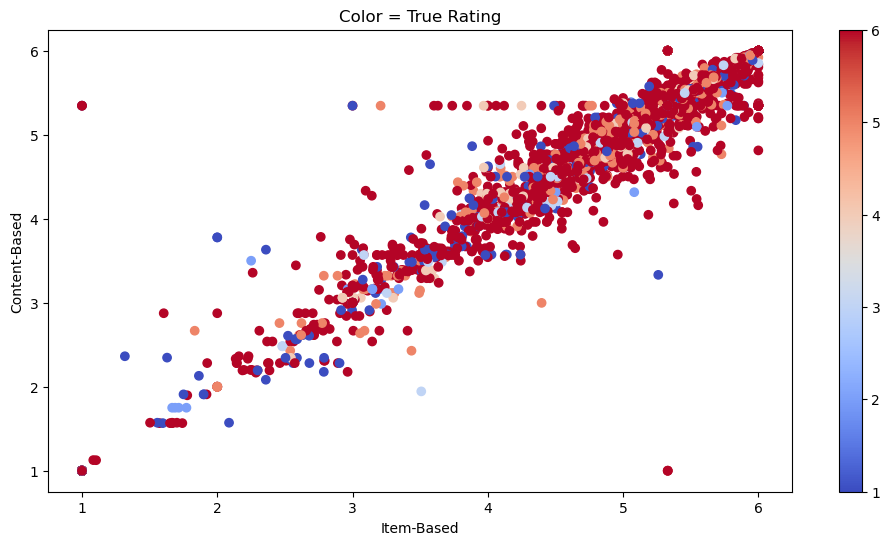

In [91]:
# visualize
scatter_df = lr_train.sample(10000, random_state=42)
plt.figure(figsize = (12, 6))
plt.scatter(x=scatter_df.ib_pred, y=scatter_df.cb_pred, c=scatter_df.target, cmap='coolwarm')
plt.xlabel('Item-Based')
plt.ylabel('Content-Based')
plt.title('Color = True Rating')
plt.colorbar()

In [92]:
# Train Linear Regression model
X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

In [93]:
# get test set
lr_test = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_test['cb_pred'] = df_pred_cb['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr = df_pred_ib.copy()
df_lr['est'] = lr_pred

In [94]:
# compute metrics
hybrid_res = eval.evaluate(df_hybrid, topn=5, rating_cutoff=4).rename(columns={'value':'Hybrid_CB_IB'})
lr_res = eval.evaluate(df_lr, topn=5, rating_cutoff=4).rename(columns={'value':'Hybrid_LR'})
lr_res

,Hybrid_LR
RMSE,1.346170
MAE,0.905248
Recall,1.000000
Precision,0.908396
F1,0.951999
NDCG@5,0.928611


In [95]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.tail()

,target,ib_pred,cb_pred
46161,6,5.523764,5.543478
46162,6,5.622828,5.543478
46163,6,5.564187,5.632773
46164,6,5.519980,5.543478
46165,6,5.545357,5.543478


In [96]:
# Random Forest Classifier

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [97]:
# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_pred_ib.copy()
df_rf['est'] = rf_pred

In [98]:
# Evaluate
rf_res = eval.prediction_metrics(df_rf).rename(columns={'value':'Hybrid_RF'})
rf_res

,Hybrid_RF
RMSE,1.333120
MAE,0.892708


In [99]:
# Evaluate
overview2 = pd.concat([overview, hybrid_res, lr_res, rf_res], axis=1)
overview2

,Content-Based,UB,IB,SVD,ALS,Clust,Hybrid_CB_IB,Hybrid_LR,Hybrid_RF
RMSE,1.485136,1.406115,1.487990,1.456155,1.381861,1.513119,1.483176,1.346170,1.333120
MAE,0.891289,0.875773,0.889512,0.900427,0.896960,0.920002,0.889864,0.905248,0.892708
Recall,0.950259,0.994992,0.948613,0.944584,0.966497,0.931874,0.950354,1.000000,NaN
Precision,0.918014,0.908373,0.919177,0.919052,0.917138,0.918708,0.918868,0.908396,NaN
F1,0.933858,0.949712,0.933663,0.931643,0.941171,0.925244,0.934346,0.951999,NaN
NDCG@5,0.963384,0.878048,0.902309,0.837528,0.842364,0.899955,0.921558,0.928611,NaN


### 10. Predict Top 5 Ingredient Reccomendations for user

In [170]:
# Top 5 recommendations for user "U6490323"
user = "U8383494"
topk = 10

lookup_ingredient = train_t1.drop_duplicates(subset=["ingredients"], keep="last").set_index("ingredients")

res = {}
for model_name, model in dict(user_based=model_ub, item_based=model_ib, als=als, svd=svd, coclustering=clust, content_based=cb).items():
    pred = predict_user_topn(model, train_t1, user=user, topk=topk, item_col="ingredients")

    # get name for each of the predicted product ids
    pred_name = [lookup_ingredient.loc[i].name for i in pred]
    res[model_name] = pred_name
 
pd.DataFrame(res)

,user_based,item_based,als,svd,coclustering,content_based
0,head iceberg lettuce,broccolini,hamburger,powdered fruit pectin,lo mein noodles,conch
1,baby back ribs,creme de cassis,powdered fruit pectin,rice paper sheets,wesson oil,gluten-free vanilla extract
2,boiled potatoes,ground marjoram,racks of baby-back pork ribs,lean ground chicken,fat-free ricotta cheese,lemon slice
3,small marshmallows,white chocolate baking squares,rotel tomatoes & chilies,low-fat vanilla yogurt,butterscotch pudding mix,imitation crabmeat
4,turkey pepperoni,chicken soup,spicy brown mustard,caramel coloring,raw sugar,cavatappi pasta
5,brown mustard seeds,wakame seaweed,fresh peach,dill pickle,pickled hot peppers,bamboo shoot
6,butter-flavored cooking spray,fingerling potatoes,dill pickle,mint chocolate chips,dried mixed fruit,baby red potatoes
7,powdered oregano,prosciutto ham,gingerroot,pace picante sauce,thyme honey,baby bok choy
8,minced chicken,no-sugar-added applesauce,cool whip,beef hot dog,fresh lasagna noodles,boneless beef chuck
9,andouille sausages,arrowroot,lemon wedges,grapefruit,whole wheat breadcrumbs,beef tenderloin


> **User-Defined Functions :** We have used below user defined function to calculate the number of ingredients match from the recommended ingredients by the model and provide the matched Recipe Names. Function used: `ingredient_match_count`

In [125]:
# Define a function to calculate the number of ingredient matches
def ingredient_match_count(ingredients_list1, ingredients_list2):
    """
    Calculates the number of ingredient matches between two lists of ingredients.
    """
    match_count = 0
    for ingredient in ingredients_list1:
        if ingredient in ingredients_list2:
            match_count += 1
    return match_count

# Call the 'predict_user_topn' function to get the list of top items for the specified user
model = cb
user = 'U6490323'  # The user ID for which you want to get item IDs
top_items = predict_user_topn(model=model, train=train, user=user, topk=10, item_col='ingredients')

# Create a set to store unique matched recipe names
matched_recipe_names = set()

# Iterate through the top_items list and find the corresponding recipe names in 'base_df'
for item in top_items:
    item_ingredients = item.split(', ')  # Split the item's ingredients into a list
    for index, row in final_basetable.iterrows():
        base_ingredients = row['ingredients']
        match_count = ingredient_match_count(item_ingredients, base_ingredients)
        if match_count ==1:
            matched_recipe_names.add(row['name'])

# Print the unique matched recipe names
print("Matched Recipe Names: ")
for name in matched_recipe_names:
    print(name)

Matched Recipe Names: 
chicken adobo in coconut milk
strawberry cookies  czechoslovakian
lemon bisque   sugar free   no bake
buttermilk chicken
low fat potato soup with chives
slow cooker french onion soup
barefoot contessa s roasted carrots
roast pork tenderloin with sun dried tomato chipotle rub
peaches and honey baked chicken
cape cod cranberry pie
jimmy carter cake ii
australian bacon and egg pie
spinach salad with honey bacon dressing
red bean soup with guacamole salsa
chicken with orange sweet and sour sauce
individual mini cherry cheesecakes
penne with swiss chard   asiago cheese
easy ham carbonara
cabbage  sausage and potato stew
bloody mary salad
coconut lime rice pudding
mock tuna salad  chickpea salad
pastry recipe for pie crust   gluten free
alaskan sourdough cornbread
german plum cake
kittencal s easy no fail make anytime turkey gravy
uncle bill s christmas fruitcake with brandy
napa cabbage salad
rhubarb pineapple pie    different and delicious
southwestern chicken and bl

In [145]:
# unnest the lists in the "ingredients" column
final_basetable_r2 = final_basetable[["ingredients", "healthy"]]
final_basetable_r2['ingredients'] = final_basetable_r2['ingredients'].apply(ast.literal_eval)
final_basetable_r2 = final_basetable_r2.explode("ingredients")

# group the data by the "healthy" column and get the unique ingredients for each group
healthy_ingredients = final_basetable_r2[final_basetable_r2["healthy"] == 1]["ingredients"].unique().tolist()
non_healthy_ingredients = final_basetable_r2[final_basetable_r2["healthy"] == 0]["ingredients"].unique().tolist()

In [146]:
# Checking the no of healthy and non-healthy ingredients
print(len(healthy_ingredients))
print(len(non_healthy_ingredients))

1884
4963


In [149]:
# match the healthy and non-healthy ingredients with the unique ingredient list
healthy_final = [ingredient for ingredient in ingredients_list if ingredient in healthy_ingredients]
non_healthy_final = [ingredient for ingredient in ingredients_list if ingredient in non_healthy_ingredients]

print("Healthy ingredients:", healthy_final)
print("Non-healthy ingredients:", non_healthy_final)

Healthy ingredients: ['salt', 'butter', 'sugar', 'onion', 'water', 'eggs', 'olive oil', 'flour', 'garlic cloves', 'milk', 'pepper', 'baking powder', 'brown sugar', 'garlic', 'all-purpose flour', 'egg', 'baking soda', 'vegetable oil', 'parmesan cheese', 'salt and pepper', 'vanilla', 'garlic powder', 'black pepper', 'cinnamon', 'lemon juice', 'sour cream', 'oil', 'vanilla extract', 'paprika', 'chicken broth', 'onions', 'soy sauce', 'celery', 'cream cheese', 'cheddar cheese', 'tomatoes', 'honey', 'garlic clove', 'worcestershire sauce', 'unsalted butter', 'cornstarch', 'mayonnaise', 'chili powder', 'fresh parsley', 'fresh ground black pepper', 'cayenne pepper', 'carrots', 'ground cumin', 'carrot', 'kosher salt', 'granulated sugar', 'extra virgin olive oil', 'parsley', 'ground cinnamon', 'potatoes', 'bacon', 'green onions', 'nutmeg', 'ground beef', 'dried oregano', 'fresh lemon juice', 'green onion', 'ground black pepper', 'dijon mustard', 'cumin', 'margarine', 'walnuts', 'boneless skinless

### 11. Manual Filtering Approach for Finding the Healthier Alternative Ingredient

In [168]:
# Example lists of healthy and unhealthy ingredients
healthy_ingredients = healthy_final
unhealthy_ingredients = non_healthy_final

# Randomly select 50% of the healthy ingredients as a sample for alternatives
healthy_final_filtered = random.sample(healthy_ingredients, int(0.5 * len(healthy_ingredients)))

# Example recommended ingredients from your model
recommended_ingredients_als = ['hamburger', 'powdered fruit pectin', 'racks of baby-back pork ribs', 'rotel tomatoes & chilies', 'spicy brown mustard', 'fresh peach', 'dill pickle', 'gingerroot', 'cool whip', 'lemon wedges']

# Define a function to determine if an ingredient is healthy or unhealthy
def determine_ingredient_healthiness(ingredient):
    if ingredient in healthy_ingredients:
        return 'healthy'
    elif ingredient in unhealthy_ingredients:
        return 'unhealthy'
    else:
        return 'unknown'

# Define a function to recommend healthier alternatives for unhealthy ingredients
def recommend_healthier_alternatives(ingredient):
    if ingredient in unhealthy_ingredients:
        filtered_healthy_ingredients = [h for h in healthy_final_filtered if h not in recommended_ingredients_als]
        if filtered_healthy_ingredients:
            return f'{random.choice(filtered_healthy_ingredients)} (healthier alternative)'
        else:
            return 'no healthier alternative found'
    return ingredient

# Determine the healthiness of the recommended ingredients and recommend healthier alternatives for unhealthy ingredients
recommended_ingredients_healthiness = {}
for ingredient in recommended_ingredients_als:
    healthiness = determine_ingredient_healthiness(ingredient)
    if healthiness == 'unhealthy':
        recommended_ingredient = recommend_healthier_alternatives(ingredient)
    else:
        recommended_ingredient = ingredient
    recommended_ingredients_healthiness[ingredient] = (healthiness, recommended_ingredient)

# Print the recommended ingredients and their healthiness status and recommended alternatives
print('Recommended Ingredients and Their Healthiness with Recommendations:')
for ingredient, (healthiness, recommended_ingredient) in recommended_ingredients_healthiness.items():
    if recommended_ingredient != ingredient:
        print(f'{ingredient}: {healthiness} -> {recommended_ingredient}')
    else:
        print(f'{ingredient}: {healthiness}')

Recommended Ingredients and Their Healthiness with Recommendations:
hamburger: unhealthy -> evaporated cane juice (healthier alternative)
powdered fruit pectin: unhealthy -> fava beans (healthier alternative)
racks of baby-back pork ribs: unhealthy -> fresh oregano (healthier alternative)
rotel tomatoes & chilies: unhealthy -> basil leaves (healthier alternative)
spicy brown mustard: healthy
fresh peach: unhealthy -> pork (healthier alternative)
dill pickle: healthy
gingerroot: healthy
cool whip: unhealthy -> ground nutmeg (healthier alternative)
lemon wedges: unhealthy -> white vinegar (healthier alternative)


In [174]:
# Example lists of healthy and unhealthy ingredients
healthy_ingredients = healthy_final
unhealthy_ingredients = non_healthy_final

# Randomly select 50% of the healthy ingredients as a sample for alternatives
healthy_final_filtered = random.sample(healthy_ingredients, int(0.5 * len(healthy_ingredients)))

# Example recommended ingredients from your model
recommended_ingredients_svd = ['powdered fruit pectin', 'rice paper sheets', 'lean ground chicken', 'low_fat vanilla yogurt', 'caramel coloring', 'dill pickel', 'mint chocolate chips', 'pace picante sauce', 'beef hot dog', 'grapefruit']

# Define a function to determine if an ingredient is healthy or unhealthy
def determine_ingredient_healthiness(ingredient):
    if ingredient in healthy_ingredients:
        return 'healthy'
    elif ingredient in unhealthy_ingredients:
        return 'unhealthy'
    else:
        return 'unknown'

# Define a function to recommend healthier alternatives for unhealthy ingredients
def recommend_healthier_alternatives(ingredient):
    if ingredient in unhealthy_ingredients:
        filtered_healthy_ingredients = [h for h in healthy_final_filtered if h not in recommended_ingredients_svd]
        if filtered_healthy_ingredients:
            return f'{random.choice(filtered_healthy_ingredients)} (healthier alternative)'
        else:
            return 'no healthier alternative found'
    return ingredient

# Determine the healthiness of the recommended ingredients and recommend healthier alternatives for unhealthy ingredients
recommended_ingredients_healthiness = {}
for ingredient in recommended_ingredients_svd:
    healthiness = determine_ingredient_healthiness(ingredient)
    if healthiness == 'unhealthy':
        recommended_ingredient = recommend_healthier_alternatives(ingredient)
    else:
        recommended_ingredient = ingredient
    recommended_ingredients_healthiness[ingredient] = (healthiness, recommended_ingredient)

# Print the recommended ingredients and their healthiness status and recommended alternatives
print('Recommended Ingredients and Their Healthiness with Recommendations:')
for ingredient, (healthiness, recommended_ingredient) in recommended_ingredients_healthiness.items():
    if recommended_ingredient != ingredient:
        print(f'{ingredient}: {healthiness} -> {recommended_ingredient}')
    else:
        print(f'{ingredient}: {healthiness}')

Recommended Ingredients and Their Healthiness with Recommendations:
powdered fruit pectin: unhealthy -> peppercorns (healthier alternative)
rice paper sheets: unhealthy -> fresh basil leaves (healthier alternative)
lean ground chicken: healthy
low_fat vanilla yogurt: unknown
caramel coloring: unhealthy -> yellow bell peppers (healthier alternative)
dill pickel: unknown
mint chocolate chips: healthy
pace picante sauce: unhealthy -> kasseri cheese (healthier alternative)
beef hot dog: unhealthy -> low sodium vegetable broth (healthier alternative)
grapefruit: unhealthy -> penne (healthier alternative)


# 4. References

 - Class Notebooks
 
 - Recipe recommendation using ingredient networks -                                                             
 https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=01de5057bc78667a40a83c2bce87649e0a4b1692 
 
 -  Ingredient recommender system - https://www.kaggle.com/code/halflings/ingredient-recommender-system/notebook
 
 -  Skewness Ranking Optimization for Personalized Recommendation -https://www.researchgate.net/publication/341699675_Skewness_Ranking_Optimization_for_Personalized_Recommendation
 
 -  Using Data for A Recipe Recommendation System - https://nycdatascience.com/blog/student-works/capstone/recipe-recommendation/
 
 -  Recommending Recipes Based on Ingredients and User Reviews -  
  https://krex.k-state.edu/bitstream/handle/2097/18154/AnirudhJagithyala2014.pdf?sequence=5&isAllowed=y